<a href="https://colab.research.google.com/github/kaiju8/GANs-Implemented/blob/main/DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
lr = 2e-4  
z_dim = 100 
img_dim = 64
channels_img = 1
batch_size = 128
num_epochs = 10

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(img_dim),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),     
    ]
) 

In [8]:
disc = Discriminator(channels_img).to(device)
gen = Generator(z_dim, channels_img).to(device)

In [9]:
print(summary(disc, input_size = (channels_img, img_dim, img_dim), batch_size = -42))
print(summary(gen, input_size = (z_dim, 1, 1), batch_size = -42))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-42, 64, 32, 32]           1,024
         LeakyReLU-2          [-42, 64, 32, 32]               0
            Conv2d-3         [-42, 128, 16, 16]         131,072
       BatchNorm2d-4         [-42, 128, 16, 16]             256
         LeakyReLU-5         [-42, 128, 16, 16]               0
            Conv2d-6           [-42, 256, 8, 8]         524,288
       BatchNorm2d-7           [-42, 256, 8, 8]             512
         LeakyReLU-8           [-42, 256, 8, 8]               0
            Conv2d-9           [-42, 512, 4, 4]       2,097,152
      BatchNorm2d-10           [-42, 512, 4, 4]           1,024
        LeakyReLU-11           [-42, 512, 4, 4]               0
           Conv2d-12             [-42, 1, 1, 1]           8,192
          Sigmoid-13             [-42, 1, 1, 1]               0
Total params: 2,763,520
Trainable param

In [10]:
dataset = datasets.MNIST(root = "dataset", transform = transforms, download = True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 157312141.47it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 92399461.35it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36600538.73it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20911667.14it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [11]:
initialize_weights(disc)
initialize_weights(gen)

opt_disc = optim.Adam(disc.parameters(), lr = lr, betas=(0.5,0.999))
opt_gen = optim.Adam(gen.parameters(), lr = lr, betas=(0.5,0.999))

In [12]:
criterion = nn.BCELoss()

In [13]:
fixed_noise = torch.randn((32, z_dim, 1, 1)).to(device)

In [14]:
def generate_img(generator, fixed_noise, channels, img_dim):
    
    fake = generator(fixed_noise).reshape(-1, channels, img_dim, img_dim)
    img_grid = torchvision.utils.make_grid(fake, normalize=True)
    return img_grid

In [15]:
def generate_interpolation(generator, z_dim, channels, img_dim):

    point_1 = torch.randn((1, z_dim, 1, 1)).to(device)
    point_2 = torch.randn((1, z_dim, 1, 1)).to(device)

    interpolated = point_1.detach().clone()
    for i in range(1, 16, 1):
        inter = torch.lerp(point_1, point_2,(i/15.0)).to(device)
        interpolated = torch.cat((interpolated, inter), 0).to(device)
        
    imgs = gen(interpolated).reshape(-1, channels_img, img_dim, img_dim)
    img_grid = torchvision.utils.make_grid(imgs, normalize=True)
    return img_grid

In [16]:
def show_grid(imgs): #Show function from documentation
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [17]:
def train_disc(real_img, fake_img, optim):

    optim.zero_grad()

    #Discriminator max log(D(real)) + log(1 - D(G(z)))

    disc_real = disc(real_img).reshape(-1)
    loss_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake_img).reshape(-1)# detach for generator stuff or a
    loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    loss_D = (loss_real + loss_fake)/2

    loss_D.backward()
    
    opt_disc.step()

    return loss_D

def train_gen(fake_img, optim):

    optim.zero_grad()
    
    #Discriminator min log(1 - D(G(z))) but better to max log(D(G(z)))
    output = disc(fake_img).reshape(-1)
    loss_G = criterion(output, torch.ones_like(output))

    loss_G.backward()

    opt_gen.step()

    return loss_G


Epoch [0/10] Batch 0/469 Discriminator loss: 0.1707, Generator loss: 1.8486
Epoch [1/10] Batch 0/469 Discriminator loss: 0.1603, Generator loss: 2.4707
Epoch [2/10] Batch 0/469 Discriminator loss: 0.4653, Generator loss: 1.4325
Epoch [3/10] Batch 0/469 Discriminator loss: 0.3345, Generator loss: 2.6504
Epoch [4/10] Batch 0/469 Discriminator loss: 0.4958, Generator loss: 3.2384
Epoch [5/10] Batch 0/469 Discriminator loss: 0.2571, Generator loss: 3.2462
Epoch [6/10] Batch 0/469 Discriminator loss: 0.2040, Generator loss: 2.7668
Epoch [7/10] Batch 0/469 Discriminator loss: 0.3998, Generator loss: 0.8400
Epoch [8/10] Batch 0/469 Discriminator loss: 0.4582, Generator loss: 1.7599
Epoch [9/10] Batch 0/469 Discriminator loss: 0.2612, Generator loss: 3.5650


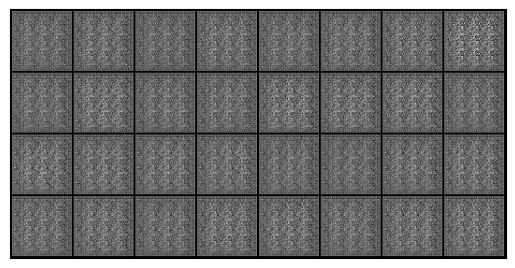

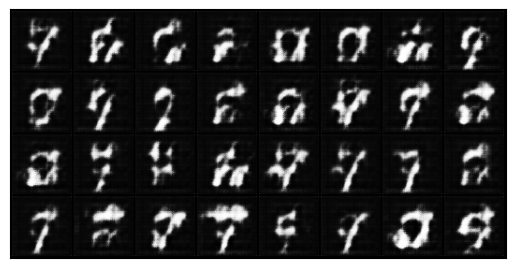

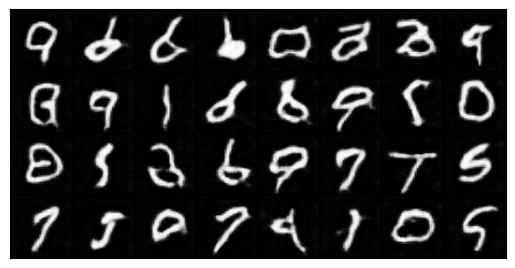

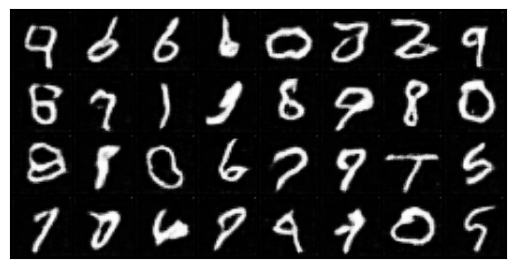

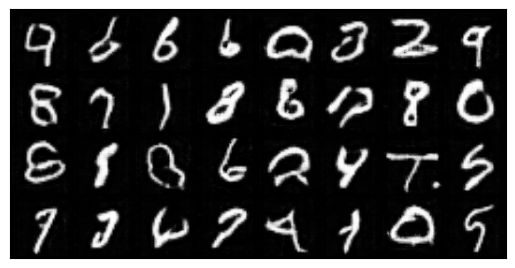

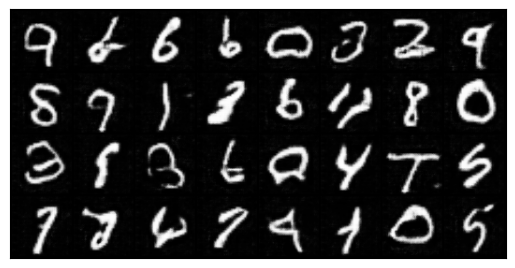

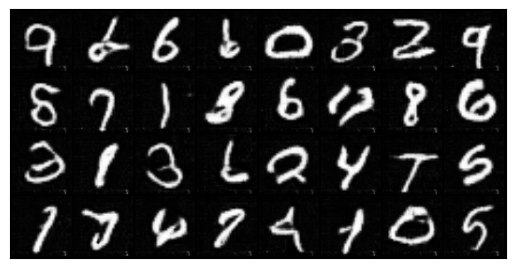

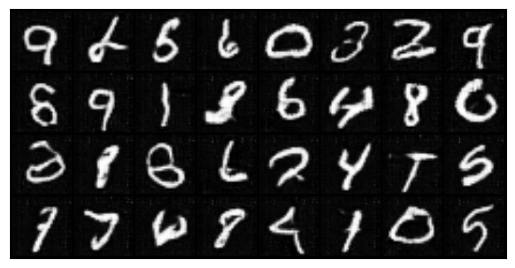

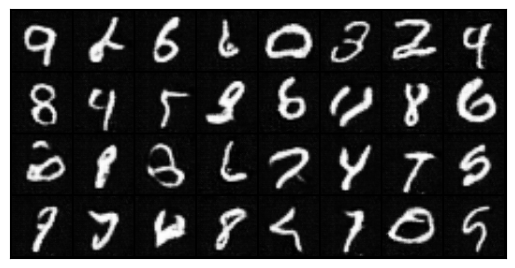

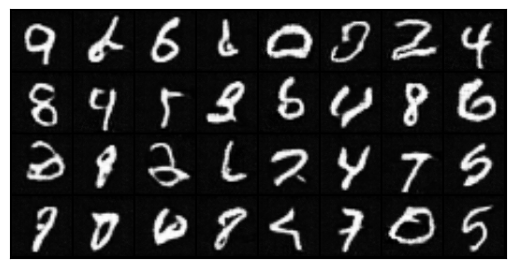

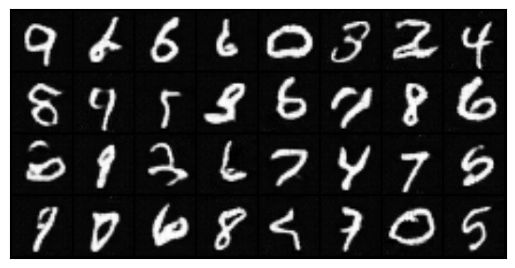

In [19]:
losses_g = []
losses_d = []

for epoch in range(num_epochs):

    loss_d = 0.0
    loss_g = 0.0

    for batch_idx, (real, _) in enumerate(loader):

        real = real.to(device)
        batch_size = real.shape[0]


        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise).detach()

        loss_d = train_disc(real, fake, opt_disc)
        losses_d.append(loss_d.detach().cpu())


        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)

        loss_g = train_gen(fake, opt_gen)
        losses_g.append(loss_g.detach().cpu())

###################################################
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} Discriminator loss: {loss_d:.4f}, Generator loss: {loss_g:.4f}")

            with torch.no_grad():
                show_grid(generate_img(gen, fixed_noise, channels_img, img_dim))
####################################################

show_grid(generate_img(gen, fixed_noise, channels_img, img_dim))

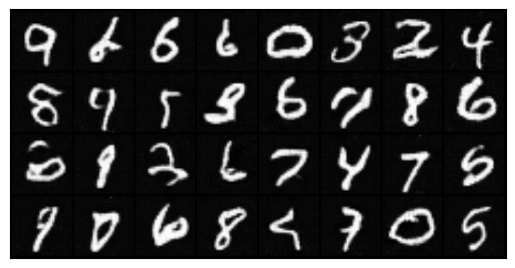

In [20]:
sample_img = generate_img(gen, fixed_noise, channels_img, img_dim)
show_grid(sample_img)
save_image(sample_img, "result.png")

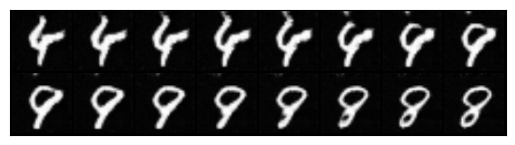

In [21]:
interpolation_img = generate_interpolation(gen, z_dim, channels_img, img_dim)
show_grid(interpolation_img)
save_image(interpolation_img, "interpolation.png")

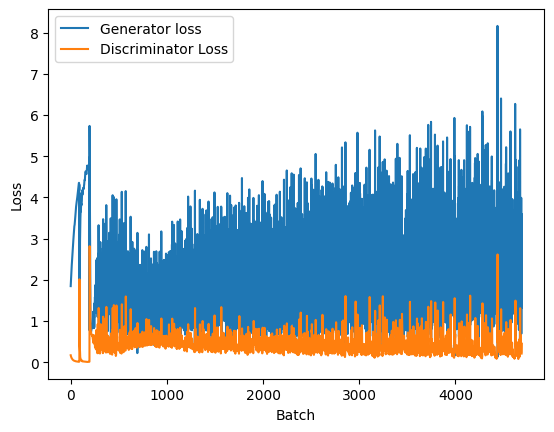

In [22]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.savefig("loss.png")
plt.show()